In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Task 3: Джойны

***Небольшой совет — выполняйте все операции поочередно, от простой к более сложной, а не пытаясь сделать всё вместе и сразу. Это поможет в отладке ваших запросов***

В этом упражнении вы создадите так называемую витрину данных. Она представляет собой таблицу, которую можно использовать для аналитических целей. Обычно она создается путем объединения нескольких отдельных таблиц. В этом упражнении мы будем собирать различные данные о наших пользователях: когда они сделали свои первые коммиты, когда они впервые посетили ленту новостей и т. д. Это поможет позднее нам выполнить анализ данных.

Что вам нужно сделать в этом упражнении (ознакомьтесь с полным описанием задания):

- [Как работает SQL Join: описание, методы, примеры](https://timeweb.com/ru/community/articles/kak-rabotaet-sql-join)

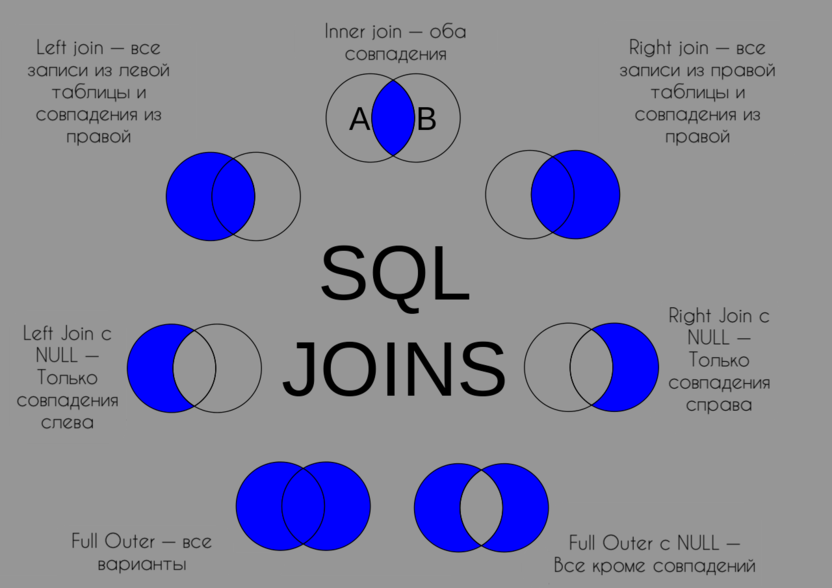

## 1. Создайте соединение с базой данных с помощью библиотеки sqlite3

In [3]:
import sqlite3
con = sqlite3.connect('/content/drive/MyDrive/School21/day11/data/checking-logs.sqlite')

## 2. Создайте новую таблицу datamart в базе данных, объединив таблицы pageviews и checker с помощью только одного запроса.

- Таблица должна содержать следующие столбцы: uid, labname, first_commit_ts, first_view_ts.

- first_commit_ts — это просто новое имя для столбца timestamp из таблицы checker; он показывает первый коммит конкретного лабораторного задания конкретного пользователя.

- f- irst_view_ts — первое посещение пользователем из таблицы pageviews, метка времени посещения пользователем ленты новостей.
- По-прежнему нужно использовать фильтр status = 'ready'.
- По-прежнему нужно использовать фильтр numTrials = 1.
- Имена лабораторных заданий по-прежнему должны быть из следующего списка: laba04, laba04s, laba05, laba06, laba06s, project1.
- Таблица должна содержать только пользователей (uid с user_*), а не администраторов.

- first_commit_ts и first_view_ts должны быть распарсены как datetime64[ns].

In [4]:
pd.io.sql.read_sql("SELECT * from pageviews LIMIT 3", con)

,index,uid,datetime
0,0,admin_1,2020-04-17 12:01:08.463179
1,1,admin_1,2020-04-17 12:01:23.743946
2,2,admin_3,2020-04-17 12:17:39.287778


In [5]:
pd.io.sql.read_sql("SELECT * from checker LIMIT 3", con)

,index,status,success,timestamp,numTrials,labname,uid
0,0,checking,0,2020-04-16 21:12:50.740474,5,None,admin_1
1,1,ready,0,2020-04-16 21:12:54.708365,5,code_rvw,admin_1
2,2,checking,0,2020-04-16 21:46:47.769088,7,None,admin_1


In [8]:
join = """

CREATE TABLE datamart AS 
            SELECT checker.uid, labname, first_commit_ts, first_view_ts
            FROM
            (select min(timestamp) as first_commit_ts, labname, uid   
                                from checker
                        WHERE uid LIKE 'user_%' and uid NOT LIKE 'admin_%'
                        and status = 'ready'
                        and numTrials = 1 
                        and labname in('laba04', 'laba04s', 'laba05', 'laba06', 'laba06s', 'project1')
                        group by uid, labname) as checker
            LEFT JOIN
            (select min(datetime) as first_view_ts,uid 
                                from pageviews
                                WHERE uid LIKE 'user_%' and uid NOT LIKE 'admin_%'
                                group by uid) as pageviews
            ON checker.uid = pageviews.uid

        """
con.cursor().execute(join)
con.commit()

In [9]:
#pd.read_sql_query('DROP TABLE datamart', con)

In [10]:
datamart = pd.io.sql.read_sql("SELECT * from datamart", con, parse_dates = ['first_commit_ts', 'first_view_ts'])
#datamart

## 3. Используя методы библиотеки Pandas, создайте два датафрейма: test и control.


- test должен включать пользователей, у которых имеются значения в first_view_ts.

- control должен включать пользователей, у которых отсутствуют значения в first_view_ts.
- Замените пропущенные значения в control средним значением first_view_ts пользователей из test (оно пригодится нам для анализа в будущем).
- Сохраните обе таблицы в базе данных (вы будете использовать их в следующих упражнениях)

- [pandas.DataFrame.to_sql](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html)

In [11]:
# test должен включать пользователей, у которых имеются значения в first_view_ts

test = datamart[datamart['first_view_ts'].notnull()]
#test

In [12]:
# control должен включать пользователей, у которых отсутствуют значения в first_view_ts

control = datamart[datamart['first_view_ts'].isnull()]
#control

In [ ]:
# Замените пропущенные значения в control средним значением first_view_ts пользователей из test (оно пригодится нам для анализа в будущем)

control['first_view_ts'] = control.apply(lambda x: test['first_view_ts'].mean(), axis=1)
#control

In [14]:
# Сохраните обе таблицы в базе данных (вы будете использовать их в следующих упражнениях)

test.to_sql('test', con, if_exists='replace', index=False)
control.to_sql('control', con, if_exists='replace', index=False)

## 4. Закройте соединение

In [15]:
con.close()